In [212]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [213]:
bitcoin_path = './data/Bitcoin_5_14_2010-5_19_2025_historical_data_coinmarketcap.xlsx'
fedfunds_path = './data/FEDFUNDS.xlsx'
us_dollar_index_path = './data/US_Dollar_Index_Historical_Data.csv'
events_impact = './data/Bitcoin_Event_Impact.csv'

df_btc = pd.read_excel(bitcoin_path)
df_fed = pd.read_excel(fedfunds_path)
df_usd = pd.read_csv(us_dollar_index_path)
df_events = pd.read_csv(events_impact)

print(df_btc.head())
print('________')
print(df_fed.head())
print('________')
print(df_usd.head())
print('________')
print(df_events.head())

                   timeOpen                 timeClose  \
0  2025-05-19T00:00:00.000Z  2025-05-19T23:59:59.999Z   
1  2025-05-18T00:00:00.000Z  2025-05-18T23:59:59.999Z   
2  2025-05-17T00:00:00.000Z  2025-05-17T23:59:59.999Z   
3  2025-05-16T00:00:00.000Z  2025-05-16T23:59:59.999Z   
4  2025-05-15T00:00:00.000Z  2025-05-15T23:59:59.999Z   

                   timeHigh                   timeLow  name           open  \
0  2025-05-19T00:09:00.000Z  2025-05-19T06:40:00.000Z  2781  106430.532703   
1  2025-05-18T23:59:00.000Z  2025-05-18T00:02:00.000Z  2781  103186.955636   
2  2025-05-17T05:04:00.000Z  2025-05-17T01:48:00.000Z  2781  103489.289736   
3  2025-05-16T16:06:00.000Z  2025-05-16T08:26:00.000Z  2781  103735.655063   
4  2025-05-15T17:46:00.000Z  2025-05-15T14:47:00.000Z  2781  103538.825684   

            high            low          close        volume     marketCap  \
0  107068.722368  102112.685460  105606.181468  6.176113e+10  2.098071e+12   
1  106597.168134  103142.604579 

In [214]:
# Normalize the time cols for merge
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp']).dt.date
df_fed['observation_date'] = pd.to_datetime(df_fed['observation_date'])
df_usd['Date'] = pd.to_datetime(df_usd['Date']).dt.date
df_events['date'] = pd.to_datetime(df_events['date']).dt.date

# DF for all day from bitcoin data
start_date = df_btc['timestamp'].min()
end_date = df_btc['timestamp'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
df_all_dates = pd.DataFrame({'timestamp': all_dates})

# DF for Fedfunds
df_fed['month'] = pd.to_datetime(df_fed['observation_date']).dt.to_period('M')
df_all_dates['month'] = pd.to_datetime(df_all_dates['timestamp']).dt.to_period('M')
df_fed_mapped = df_all_dates.merge(df_fed[['month', 'FEDFUNDS']], on='month', how='left')
print(df_fed_mapped.head())

# DF for US_Dollar_Index
df_usd = df_usd[['Date', 'Price']].rename(columns={'Price': 'US_Dollar_Price'})
df_usd = df_all_dates.merge(df_usd, left_on='timestamp', right_on='Date', how='left')
df_usd['US_Dollar_Price'] = df_usd['US_Dollar_Price'].ffill()
print(df_usd.head())

# DF for Events Impact
impact_data = []
for _, row in df_events.iterrows():
  event_date = row['date']
  impact = row['impact']
  days_before = row['days_before']
  days_after = row['days_after']

  start_date = event_date - pd.Timedelta(days=days_before)
  end_date = event_date + pd.Timedelta(days=days_after)
  date_range = pd.date_range(start=start_date, end=end_date, freq='D').date

  for d in date_range:
    impact_data.append({'timestamp': d, 'impact': impact})

df_impact = pd.DataFrame(impact_data)
print(df_impact.head())

    timestamp    month  FEDFUNDS
0  2010-07-14  2010-07      0.18
1  2010-07-15  2010-07      0.18
2  2010-07-16  2010-07      0.18
3  2010-07-17  2010-07      0.18
4  2010-07-18  2010-07      0.18
    timestamp    month        Date  US_Dollar_Price
0  2010-07-14  2010-07  2010-07-14            83.43
1  2010-07-15  2010-07  2010-07-15            82.56
2  2010-07-16  2010-07  2010-07-16            82.49
3  2010-07-17  2010-07         NaN            82.49
4  2010-07-18  2010-07         NaN            82.49
    timestamp  impact
0  2010-07-13       1
1  2010-07-14       1
2  2010-07-15       1
3  2010-07-16       1
4  2010-07-17       1


In [215]:
# Merge all df into 1 df
df_merged = df_btc.merge(df_fed_mapped[['timestamp', 'FEDFUNDS']], how='left', on='timestamp')
df_merged = df_merged.merge(df_usd[['timestamp', 'US_Dollar_Price']], how='left', on='timestamp')
df_merged = df_merged.merge(df_impact, how='left', on='timestamp')

# Fill 0 for all days with no impact
df_merged['impact'] = df_merged['impact'].fillna(0).astype(int)

df_final = df_merged

In [216]:
df_final.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp,FEDFUNDS,US_Dollar_Price,impact
0,2025-05-19T00:00:00.000Z,2025-05-19T23:59:59.999Z,2025-05-19T00:09:00.000Z,2025-05-19T06:40:00.000Z,2781,106430.532703,107068.722368,102112.685460,105606.181468,6.176113e+10,2.098071e+12,2025-05-19,4.33,100.43,1
1,2025-05-18T00:00:00.000Z,2025-05-18T23:59:59.999Z,2025-05-18T23:59:00.000Z,2025-05-18T00:02:00.000Z,2781,103186.955636,106597.168134,103142.604579,106446.010554,4.988708e+10,2.114273e+12,2025-05-18,4.33,101.09,1
2,2025-05-17T00:00:00.000Z,2025-05-17T23:59:59.999Z,2025-05-17T05:04:00.000Z,2025-05-17T01:48:00.000Z,2781,103489.289736,103716.948988,102659.177081,103191.085478,3.789855e+10,2.049839e+12,2025-05-17,4.33,101.09,1
3,2025-05-16T00:00:00.000Z,2025-05-16T23:59:59.999Z,2025-05-16T16:06:00.000Z,2025-05-16T08:26:00.000Z,2781,103735.655063,104533.486651,103137.478737,103489.291712,4.438650e+10,2.055845e+12,2025-05-16,4.33,101.09,1
4,2025-05-15T00:00:00.000Z,2025-05-15T23:59:59.999Z,2025-05-15T17:46:00.000Z,2025-05-15T14:47:00.000Z,2781,103538.825684,104153.619877,101440.812464,103744.643581,5.040824e+10,2.060734e+12,2025-05-15,4.33,100.88,1


In [217]:
df_final = df_final.drop('name', axis=1)  # Tất cả đều cùng 1 id là 2781
df_final = df_final.drop('timeOpen', axis=1)  # Ko cần, do timeOpen là 0:0:0 timestamp
df_final = df_final.drop('timeClose', axis=1)  # Ko cần, do là cuối ngay của timestamp

In [218]:
df_final.head()

,timeHigh,timeLow,open,high,low,close,volume,marketCap,timestamp,FEDFUNDS,US_Dollar_Price,impact
0,2025-05-19T00:09:00.000Z,2025-05-19T06:40:00.000Z,106430.532703,107068.722368,102112.685460,105606.181468,6.176113e+10,2.098071e+12,2025-05-19,4.33,100.43,1
1,2025-05-18T23:59:00.000Z,2025-05-18T00:02:00.000Z,103186.955636,106597.168134,103142.604579,106446.010554,4.988708e+10,2.114273e+12,2025-05-18,4.33,101.09,1
2,2025-05-17T05:04:00.000Z,2025-05-17T01:48:00.000Z,103489.289736,103716.948988,102659.177081,103191.085478,3.789855e+10,2.049839e+12,2025-05-17,4.33,101.09,1
3,2025-05-16T16:06:00.000Z,2025-05-16T08:26:00.000Z,103735.655063,104533.486651,103137.478737,103489.291712,4.438650e+10,2.055845e+12,2025-05-16,4.33,101.09,1
4,2025-05-15T17:46:00.000Z,2025-05-15T14:47:00.000Z,103538.825684,104153.619877,101440.812464,103744.643581,5.040824e+10,2.060734e+12,2025-05-15,4.33,100.88,1


In [219]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timeHigh         5429 non-null   object 
 1   timeLow          5429 non-null   object 
 2   open             5429 non-null   float64
 3   high             5429 non-null   float64
 4   low              5429 non-null   float64
 5   close            5429 non-null   float64
 6   volume           5429 non-null   float64
 7   marketCap        5429 non-null   float64
 8   timestamp        5429 non-null   object 
 9   FEDFUNDS         5429 non-null   float64
 10  US_Dollar_Price  5429 non-null   float64
 11  impact           5429 non-null   int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 509.1+ KB


In [220]:
df_final.isnull().sum()

timeHigh           0
timeLow            0
open               0
high               0
low                0
close              0
volume             0
marketCap          0
timestamp          0
FEDFUNDS           0
US_Dollar_Price    0
impact             0
dtype: int64

In [221]:
time_cols = ['timeHigh', 'timeLow', 'timestamp']
for col in time_cols:
  df_final[col] = pd.to_datetime(df_final[col])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   timeHigh         5429 non-null   datetime64[ns, UTC]
 1   timeLow          5429 non-null   datetime64[ns, UTC]
 2   open             5429 non-null   float64            
 3   high             5429 non-null   float64            
 4   low              5429 non-null   float64            
 5   close            5429 non-null   float64            
 6   volume           5429 non-null   float64            
 7   marketCap        5429 non-null   float64            
 8   timestamp        5429 non-null   datetime64[ns]     
 9   FEDFUNDS         5429 non-null   float64            
 10  US_Dollar_Price  5429 non-null   float64            
 11  impact           5429 non-null   int64              
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(8), int64(1)
memory us

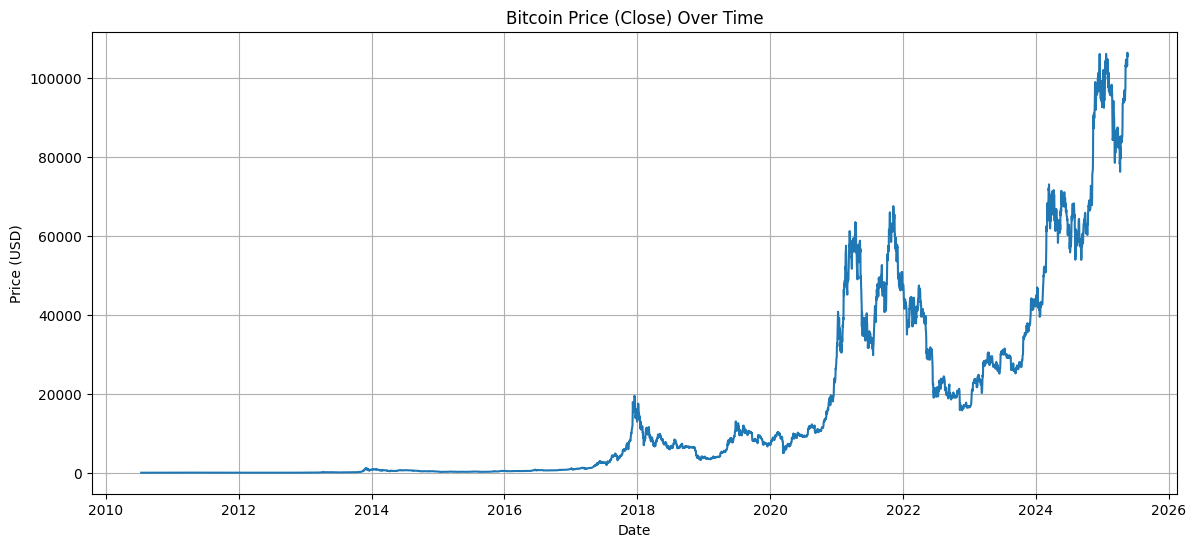

In [222]:
df_final = df_final.sort_values('timestamp')

# Draw close price over time
plt.figure(figsize=(14, 6))
plt.plot(df_final['timestamp'], df_final['close'])
plt.title("Bitcoin Price (Close) Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


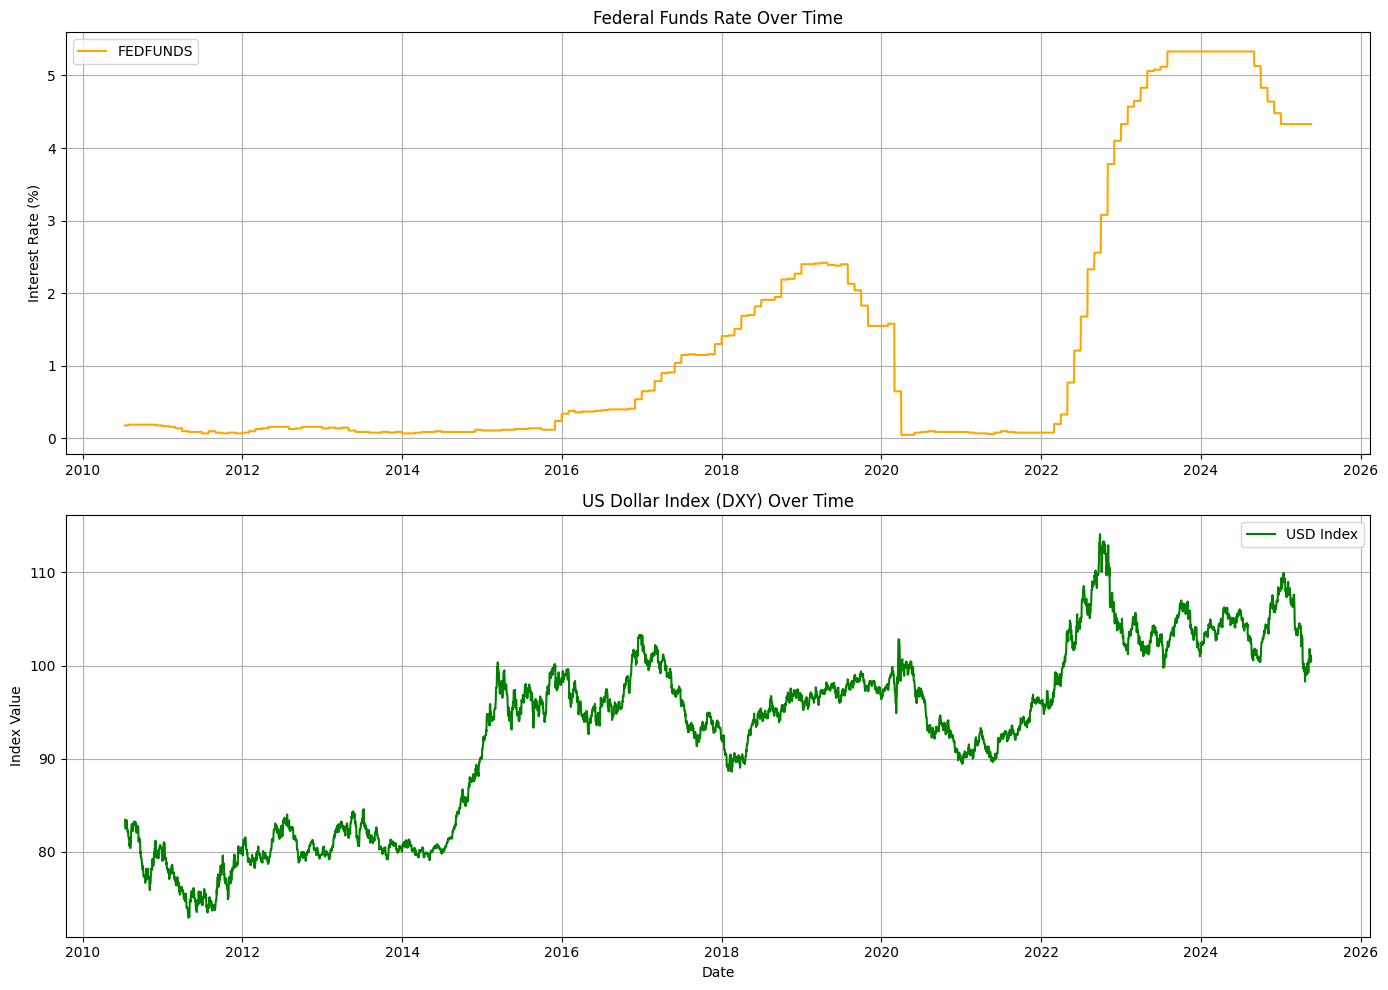

In [223]:
# Draw FEDFUNDS and US_Dollar_Price over time
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(df_final['timestamp'], df_final['FEDFUNDS'], label="FEDFUNDS", color='orange')
ax[0].set_title("Federal Funds Rate Over Time")
ax[0].set_ylabel("Interest Rate (%)")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(df_final['timestamp'], df_final['US_Dollar_Price'], label="USD Index", color='green')
ax[1].set_title("US Dollar Index (DXY) Over Time")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Index Value")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

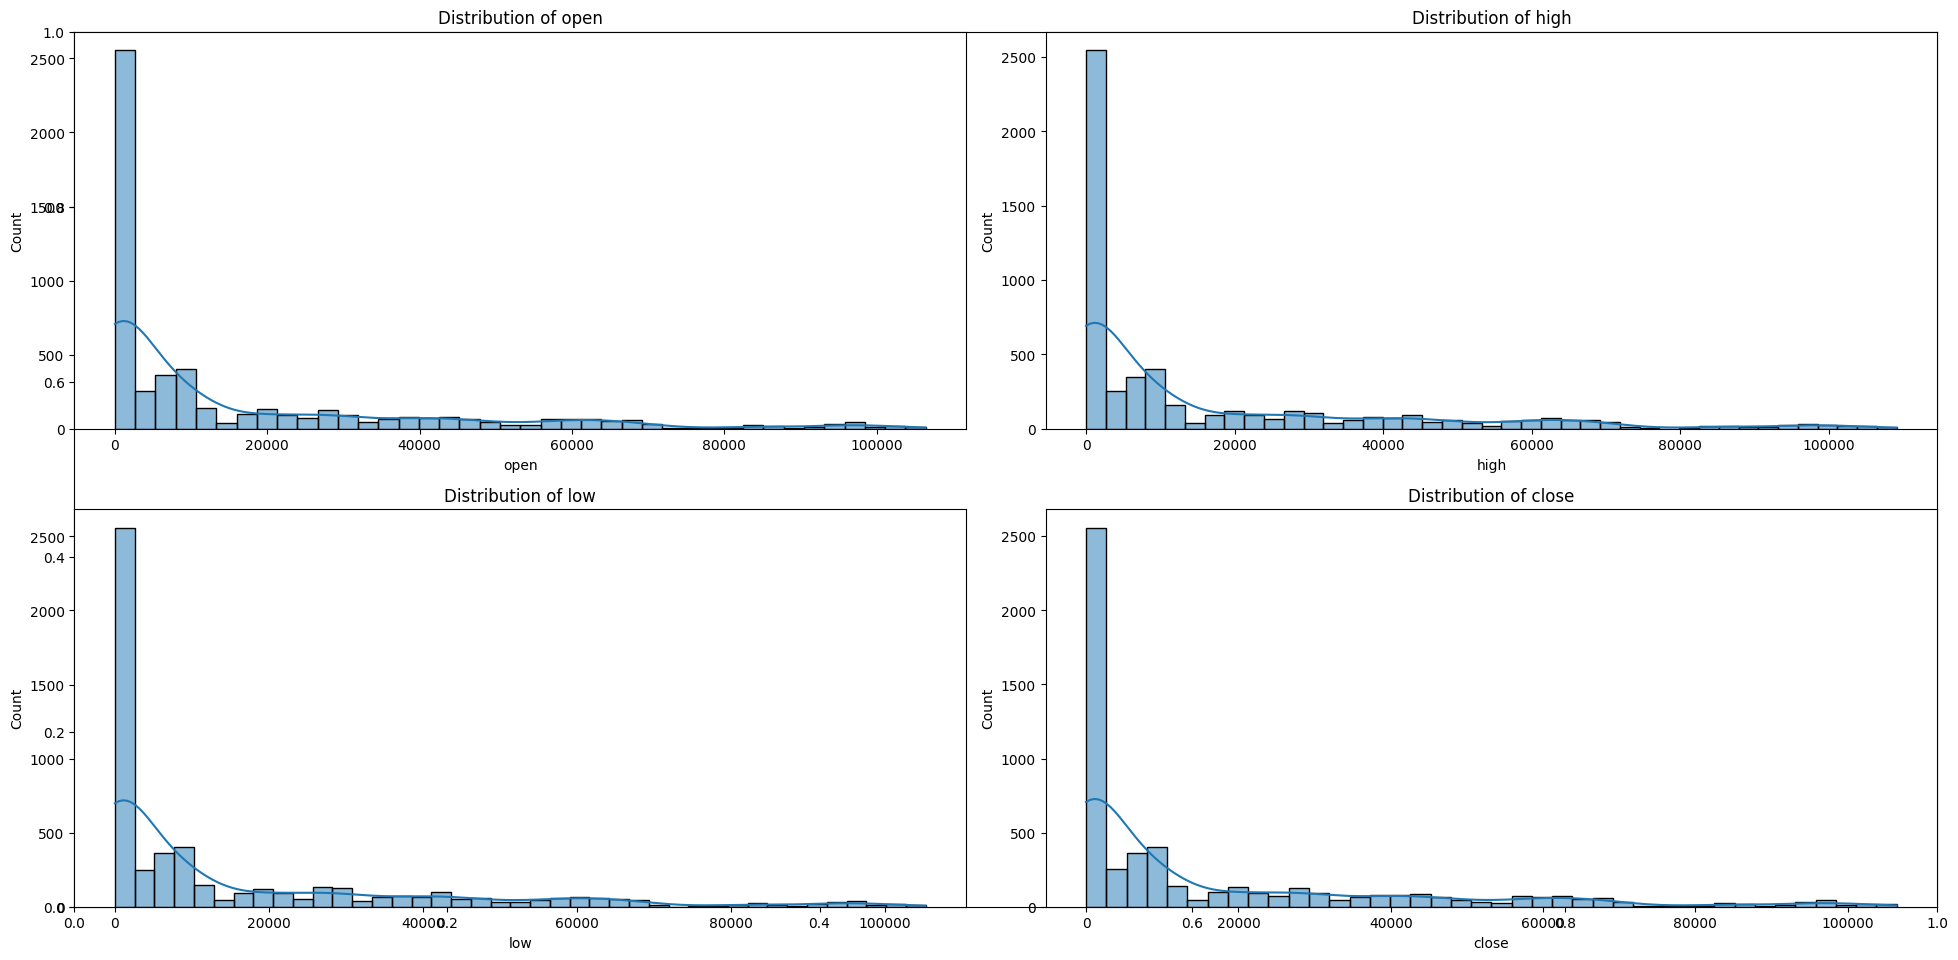

In [224]:
features = ['open', 'high', 'low', 'close']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_final[col], kde=True)  # kde=True để vẽ cả đường mật độ
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

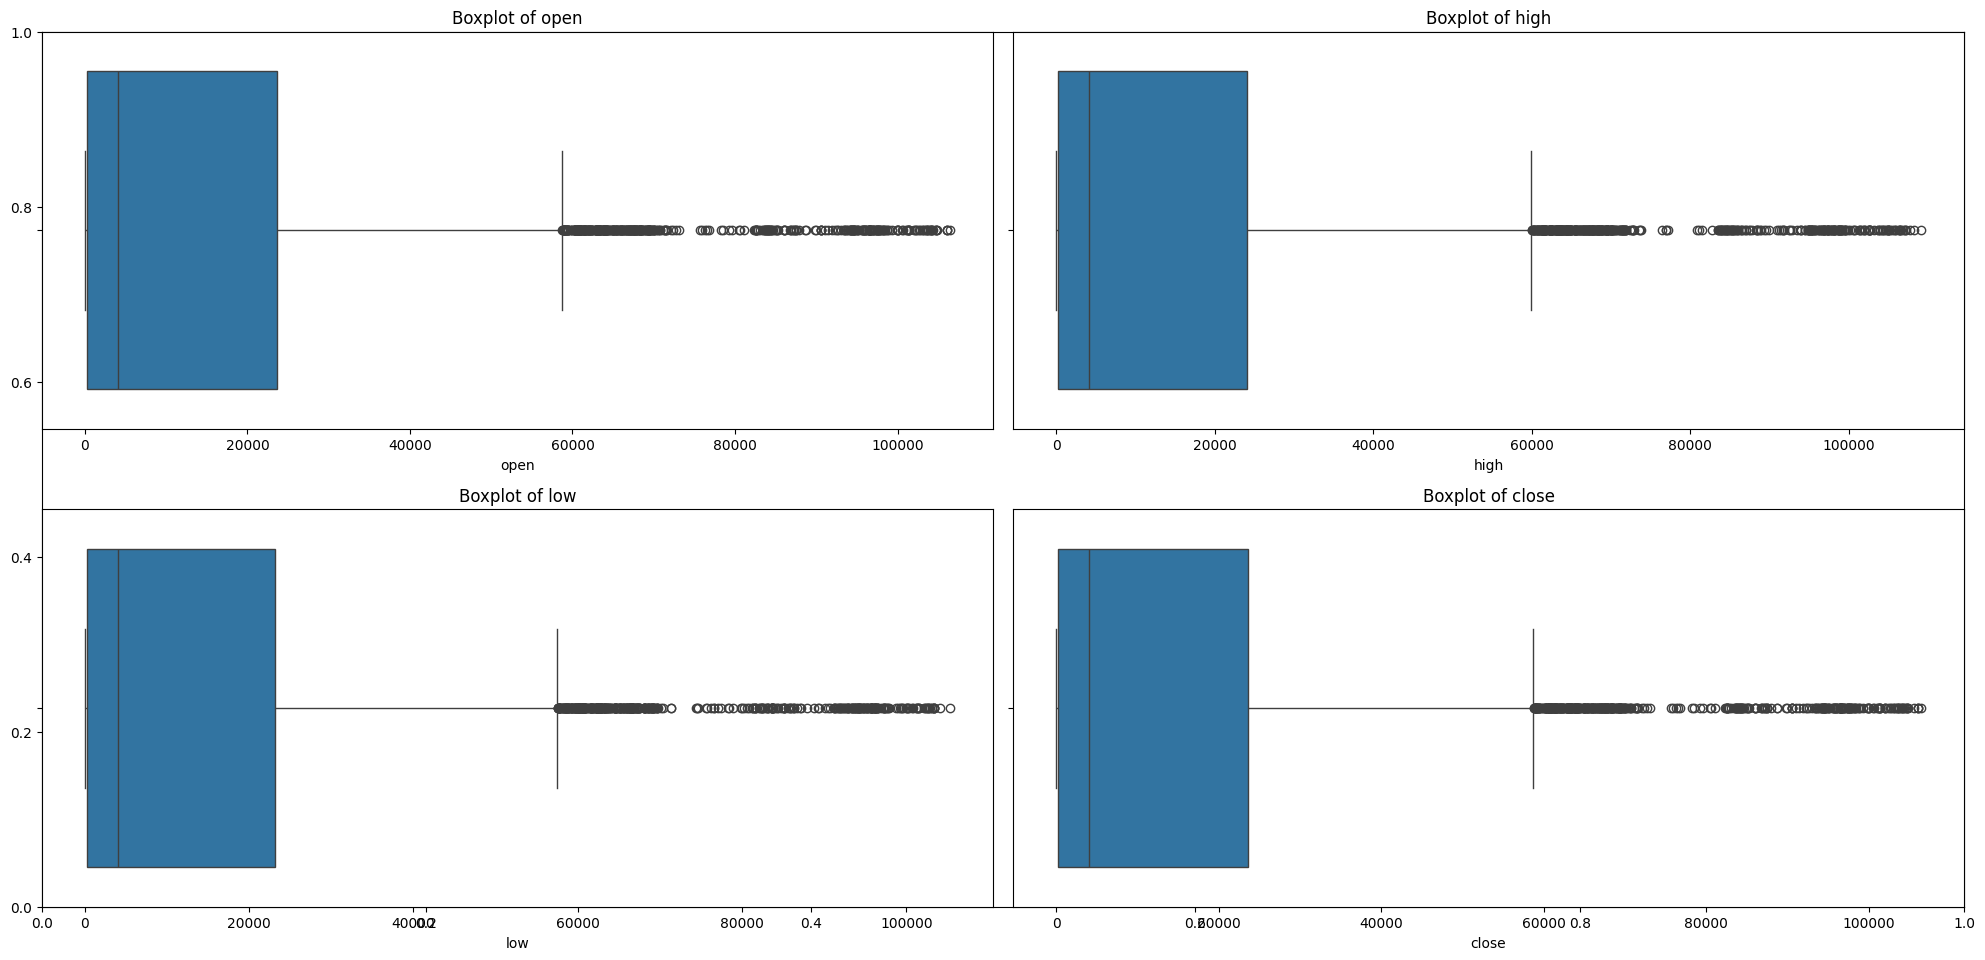

In [225]:
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df_final[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

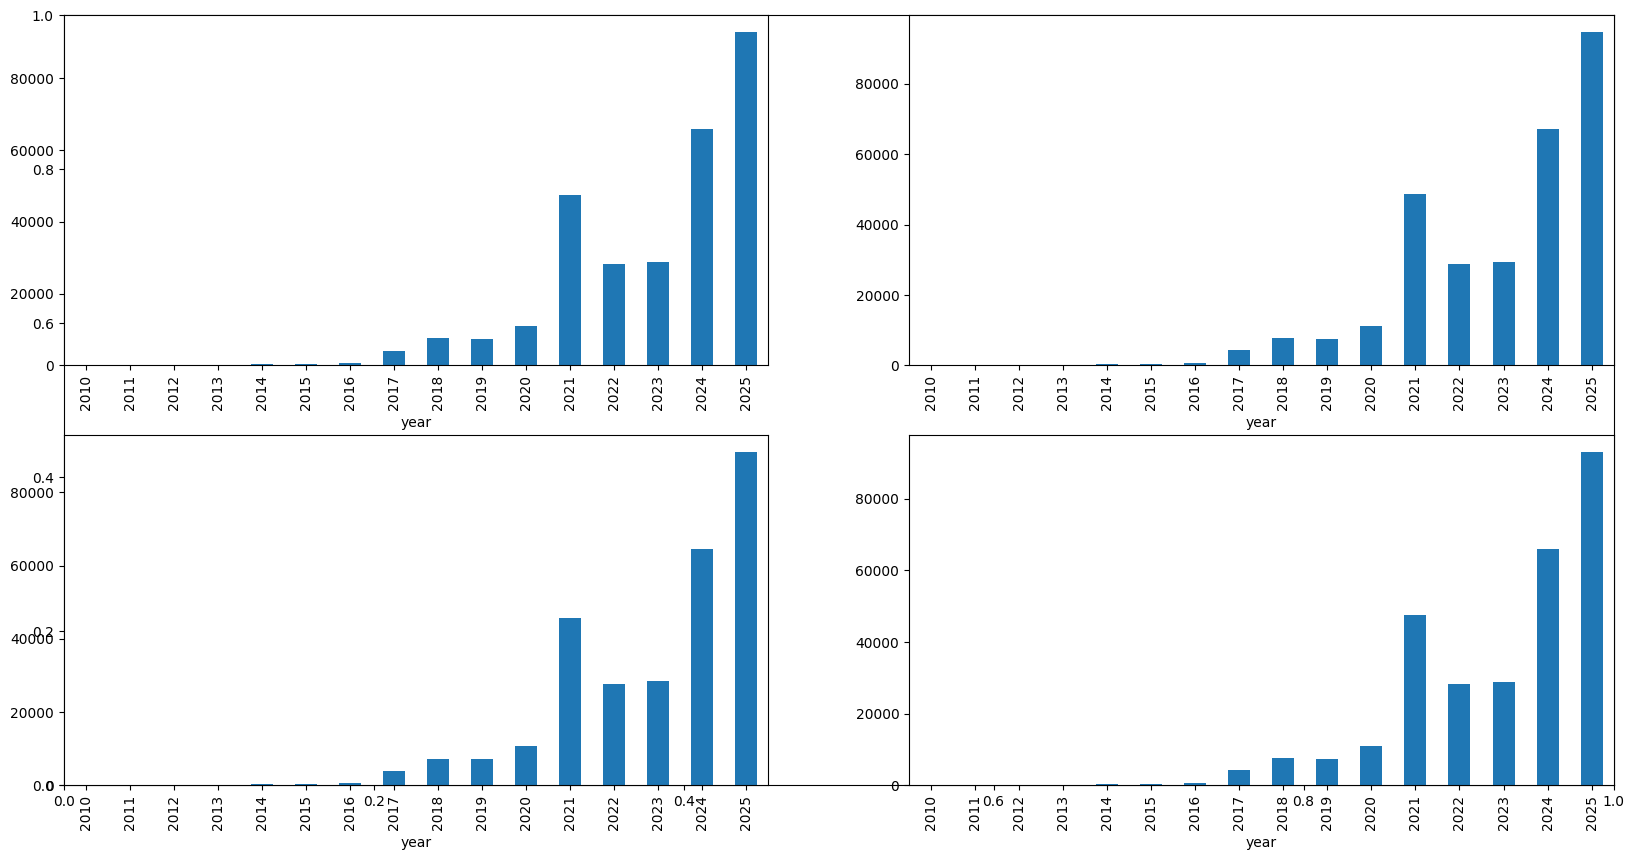

In [226]:
df_final['year'] = df_final['timestamp'].dt.year
df_final['month'] = df_final['timestamp'].dt.month
df_final['day'] = df_final['timestamp'].dt.day

data_grouped = df_final.groupby('year').mean()
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
  plt.subplot(2, 2, i + 1)
  data_grouped[col].plot.bar()
plt.show()

In [227]:
df_final['target_close'] = np.where(df_final['close'].shift(-1) > df_final['close'], 1, 0)

df_final = df_final.dropna()
df_final = df_final.reset_index(drop=True)

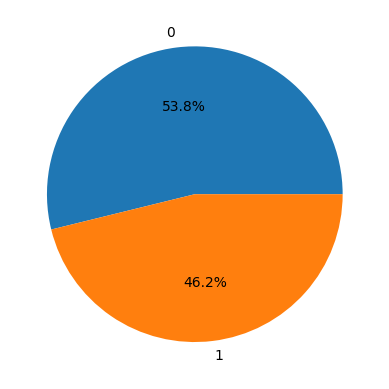

In [228]:
plt.pie(df_final['target_close'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

In [229]:
df_final['range_high_low'] = df_final['high'] - df_final['low']
df_final['change_open_close'] = df_final['close'] - df_final['open']

# Drop cols after using
df_final = df_final.drop(['timeHigh', 'timeLow', 'timestamp'], axis=1)
df_final.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,impact,year,month,day,target_close,range_high_low,change_open_close
0,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,0.18,83.43,1,2010,7,14,1,0.012942,-0.001755
1,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,0.18,82.56,1,2010,7,15,1,0.013985,0.001165
2,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,0.18,82.49,1,2010,7,16,0,0.014737,0.008490
3,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,0.18,82.49,1,2010,7,17,1,0.020317,-0.000507
4,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,0.18,82.49,1,2010,7,18,0,0.016637,0.012726


In [230]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
impact_encoded = encoder.fit_transform(df_final[['impact']])
impact_df = pd.DataFrame(impact_encoded, columns=encoder.get_feature_names_out(['impact']))
df_final = pd.concat([df_final, impact_df], axis=1)
df_final = df_final.drop('impact', axis=1)

In [231]:
df_final.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,year,month,day,target_close,range_high_low,change_open_close,impact_0,impact_1
0,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,0.18,83.43,2010,7,14,1,0.012942,-0.001755,0.0,1.0
1,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,0.18,82.56,2010,7,15,1,0.013985,0.001165,0.0,1.0
2,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,0.18,82.49,2010,7,16,0,0.014737,0.008490,0.0,1.0
3,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,0.18,82.49,2010,7,17,1,0.020317,-0.000507,0.0,1.0
4,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,0.18,82.49,2010,7,18,0,0.016637,0.012726,0.0,1.0


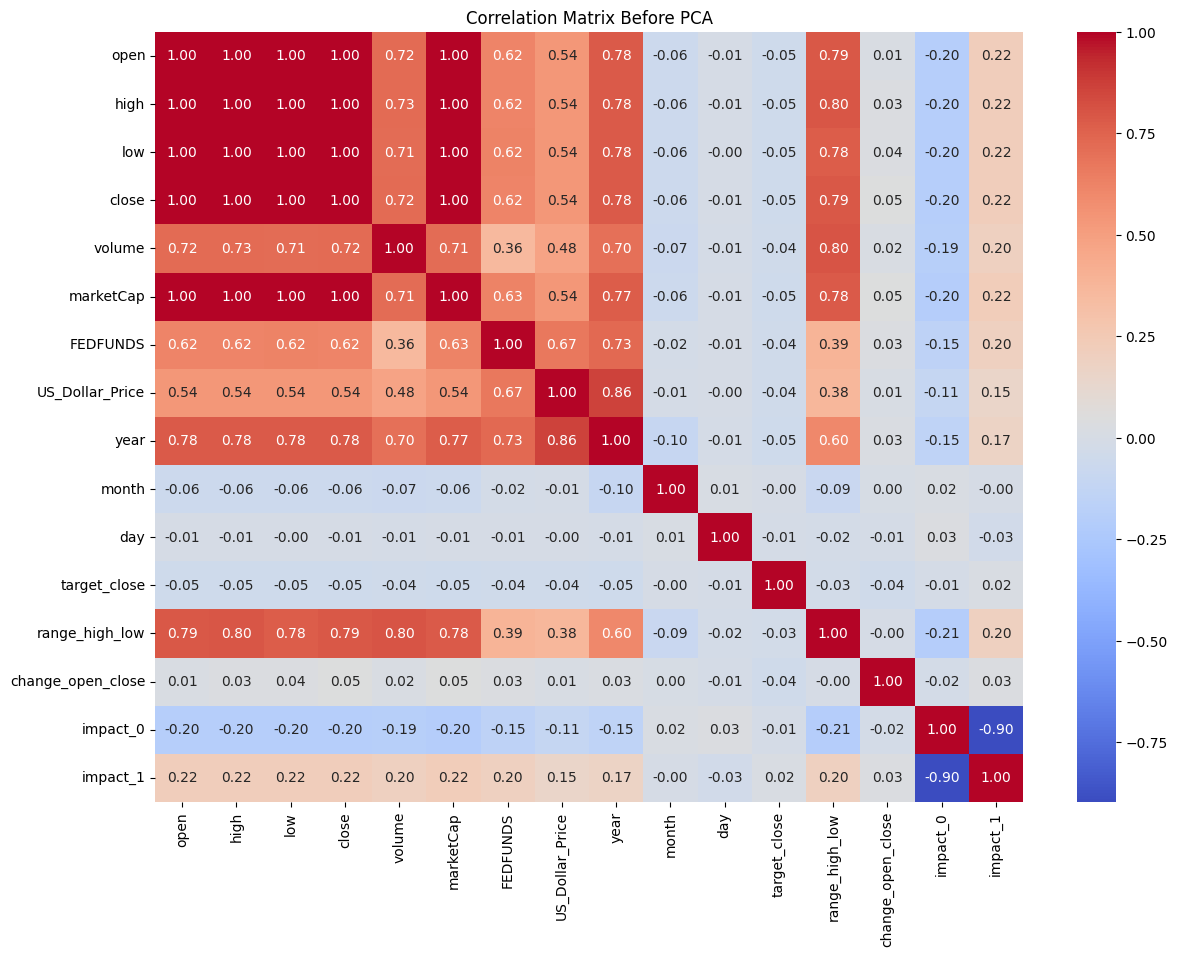

In [232]:
# Ma trận tương quan
correlation_matrix = df_final.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Before PCA')
plt.show()

In [233]:
scaler_for_cols = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'FEDFUNDS', 'US_Dollar_Price',
            'change_open_close'
            ]

scaler_X = StandardScaler()
X_scaled = df_final.copy()
X_scaled[scaler_for_cols] = scaler_X.fit_transform(X_scaled[scaler_for_cols])

X_scaled.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,year,month,day,target_close,range_high_low,change_open_close,impact_0,impact_1
0,-0.669247,-0.669965,-0.668366,-0.669195,-0.708119,-0.653089,-0.657554,-1.003403,2010,7,14,1,0.012942,-0.020547,0.0,1.0
1,-0.669247,-0.669965,-0.668366,-0.669195,-0.708119,-0.653089,-0.657554,-1.095773,2010,7,15,1,0.013985,-0.020543,0.0,1.0
2,-0.669247,-0.669965,-0.668366,-0.669195,-0.708119,-0.653089,-0.657554,-1.103205,2010,7,16,0,0.014737,-0.020535,0.0,1.0
3,-0.669247,-0.669964,-0.668366,-0.669195,-0.708119,-0.653089,-0.657554,-1.103205,2010,7,17,1,0.020317,-0.020545,0.0,1.0
4,-0.669247,-0.669964,-0.668365,-0.669194,-0.708119,-0.653089,-0.657554,-1.103205,2010,7,18,0,0.016637,-0.020530,0.0,1.0


In [234]:
X = X_scaled.drop(columns=['open', 'high', 'low', 'close', 'target_close'])
y = X_scaled['target_close']

In [235]:
# split_index = int(len(X_scaled) * 0.8)
# X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X[:len(X)//7], X[len(X)//7:], y[:len(X)//7], y[len(X)//7:]

In [236]:
print(X_train[0:2])
print(y_train[0:2])                

     volume  marketCap  FEDFUNDS  US_Dollar_Price  year  month  day  \
0 -0.708119  -0.653089 -0.657554        -1.003403  2010      7   14   
1 -0.708119  -0.653089 -0.657554        -1.095773  2010      7   15   

   range_high_low  change_open_close  impact_0  impact_1  
0        0.012942          -0.020547       0.0       1.0  
1        0.013985          -0.020543       0.0       1.0  
0    1
1    1
Name: target_close, dtype: int64


In [ ]:
# Precision, Recall, F1-score

# accuracy = (TP + TN) / (TP + TN + FP + FN)  Độ chính xác
# precision = TP / (TP + FP)                  Độ chính xác của lớp target_close
# recall = TP / (TP + FN)                     Tỷ lệ phát hiện target_close đúng
# f1_score = 2 * (precision * recall) / (precision + recall)

models = {
    'Logistic Regression': LogisticRegression(solver="saga", max_iter=10000),
    'SVC': SVC(kernel='poly', probability=True),
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {model.score(X_test, y_test) * 100:.2f}%")

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    results[model_name] = {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
    }

    print(f"{model_name} - Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

Accuracy: 48.67%
Logistic Regression - Accuracy: 0.49, Precision: 0.52, Recall: 0.51, F1-score: 0.43
Accuracy: 53.42%
SVC - Accuracy: 0.53, Precision: 0.27, Recall: 0.50, F1-score: 0.35


d:\Coding\AI\BitcoinML\b_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [238]:
def preprocess_data(data_dict, scaler_X, encoder, scaler_for_cols):
    data = pd.DataFrame([data_dict])

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = data['timestamp'].dt.day

    data['change_open_close'] = data['close'] - data['open']
    data['percentage_change'] = (data['change_open_close'] / data['open']) * 100

    data = data.drop(['timeHigh', 'timeLow'], axis=1)
    data.set_index('timestamp', inplace=True)

    encoded_cols = encoder.transform(data[['impact']])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['impact']))
    encoded_df.index = data.index
    data = pd.concat([data, encoded_df], axis=1)
    data = data.drop('impact', axis=1)

    scaled_df = data.copy()
    scaled_df[scaler_for_cols] = scaler_X.transform(data[scaler_for_cols])

    return scaled_df

def predict_in_day(model, X):
    predicted = model.predict(X)

    return {
        'predicted_close': predicted[0],
    }

In [239]:
def process_pred(
    model,
    initial_data_dict,
    scaler_X,
    encoder,
    scaler_for_cols,
    n_days=5
):
    forecast_dates = []
    forecast_prices = []

    data_dict = initial_data_dict.copy()

    for i in range(n_days):
        # Tiền xử lý
        X_input = preprocess_data(data_dict, scaler_X, encoder, scaler_for_cols)
        
        # Dự đoán
        result = predict_in_day(model, X_input)
        predicted_close = result['predicted_close']
        
        # Lưu lại ngày và giá
        forecast_date = pd.to_datetime(data_dict['timestamp']) + timedelta(days=1)
        forecast_dates.append(forecast_date)
        forecast_prices.append(predicted_close)

        # Cập nhật dữ liệu cho ngày kế tiếp
        data_dict['timestamp'] = forecast_date.strftime("%Y-%m-%d %H:%M:%S")
        data_dict['close'] = predicted_close  # dùng giá dự đoán làm close cho ngày tiếp theo

        # Cập nhật dữ liệu khác nếu cần

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_dates, forecast_prices, marker='o', linestyle='--', color='blue', label='Dự đoán')
    plt.title(f'Dự đoán giá trong {n_days} ngày tiếp theo')
    plt.xlabel('Ngày')
    plt.ylabel('Giá đóng cửa dự đoán')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return forecast_dates, forecast_prices

In [240]:
best_model = models['Linear Regression']  # hoặc Random Forest, Linear Regression
initial_data_dict = {
    'open': 106430.532703,
    'high': 107068.722368,
    'low': 102112.685460,
    'close': 105606.1814675408,
    'volume': 6.176113e+10,
    'marketCap': 2.098071e+12,
    'FEDFUNDS': 4.33,
    'US_Dollar_Price': 100.43,
    'impact': 1,
    'timeHigh': '2025-05-19T00:09:00.000Z',
    'timeLow': '2025-05-19T06:40:00.000Z',
    'timestamp': '2025-05-19'
}
forecast_dates, forecast_prices = process_pred(best_model, initial_data_dict, scaler_X, encoder, scaler_for_cols, n_days=30)


KeyError: 'Linear Regression'

In [ ]:
import joblib

state = {
    'models': models,
    'scaler_X': scaler_X,
    'encoder': encoder,
    'scaler_for_cols': scaler_for_cols
}

joblib.dump(state, 'predictor_state.pkl')

# Load lại sau
# state = joblib.load('predictor_state.pkl')
# models = state['models']
# scaler_X = state['scaler_X']
# encoder = state['encoder']
# numeric_cols = state['numeric_cols']

['predictor_state.pkl']